In [1]:
import matplotlib.pyplot as plt
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import nibabel as nib
from scipy import ndimage
import glob
import sys,os
from natsort import natsorted
import tensorflow_probability as tfp
import random
from aifnet_utils.preprocess import read_nifti_file, normalize, normalize_aif, process_scan
from aifnet_utils.losses import MaxCorrelation
from aifnet_utils.isles_loaders import read_isles_annotations, read_isles_volumes

%matplotlib inline

In [2]:
root_dir     = '/Users/sebastianotalora/work/postdoc/data/ISLES/'
aif_annotations_path = '/Users/sebastianotalora/work/postdoc/data/ISLES/annotated_aif_vof.csv'
min_num_volumes_ctp = 43
ROOT_EXP = '/Users/sebastianotalora/work/postdoc/ctp/aifnet_replication'


In [3]:
aif_annotations, vof_annotations = read_isles_annotations(aif_annotations_path, root_dir, 
                                         min_num_volumes_ctp, return_aif_only = False)

In [7]:
ctp_volumes = read_isles_volumes(root_dir, aif_annotations_path, min_num_volumes_ctp, take_two_slices_only=False)

In [8]:
print(len(ctp_volumes), len(aif_annotations))

94 94


In [9]:
len(aif_annotations)

94

In [10]:
def get_model_onehead(width=256, height=256, num_channels=43):
    """Build a 3D convolutional neural network model."""
    #width and height of the PCT is 256, the number of slices is variable, and the number of channels are
    #the number of timepoints in the PCT sequence        
    inputs = keras.Input((width, height, None , 43))

    x = layers.Conv3D(filters=16, kernel_size=(3,3,1), activation="relu", data_format='channels_last', padding='same')(inputs)        
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv3D(filters=32, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv3D(filters=64, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv3D(filters=128, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)

    #x = layers.Conv3D(filters=256, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)
    x = layers.Dropout(0.3)(x)
    Lout = layers.Conv3D(filters=1, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)

    P_vol_aif = tf.keras.activations.softmax(Lout,name="Pvol_aif")
    
    #Voxelwise multiplication of P_vol and each of the CTP time points    
    voxelwise_mult_each_ctp = tf.keras.layers.Multiply()([inputs,P_vol_aif])    
        
    #The 3D average pooling block averages the volumetric information along the x-y-z axes, 
    #such that the predicted vascular function y(t) is a 1D vector of length T.
    x_aif = layers.GlobalAveragePooling3D(data_format='channels_last')(voxelwise_mult_each_ctp)
    #x = layers.Dense(units=512, activation="relu")(x)
    
    outputs_aif = layers.Dense(units=num_channels, activation="linear",name="aif_pred")(x_aif)

    # Define the model.
    model = keras.Model(inputs, outputs_aif, name="aifnet")
    return model

In [11]:
initial_learning_rate = 0.011
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

In [12]:
# Build model.
model = get_model_onehead(width=256, height=256, num_channels=43)
model.summary()

Model: "aifnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, No 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 256, 256, Non 6208        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, Non 0           conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 256, 256, Non 13856       dropout[0][0]                    
_____________________________________________________________________________________________

In [13]:
model.compile(
    loss=MaxCorrelation,#"mse",
    optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate, clipnorm=1),
    metrics=["mae"])

In [14]:
# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="train_acc", patience=15)
path_checkpointer_model = ROOT_EXP +'results/' 
path_checkpointer_model += 'aifnet_2Pvol_' + str(initial_learning_rate)  + '.hdf5'
path_tensorboard_log    = ROOT_EXP + 'results/logsTensorBoard/'
path_tensorboard_log    += 'aifnet_2Pvol_' + str(initial_learning_rate) 

checkpointer = ModelCheckpoint(filepath=path_checkpointer_model, monitor='train_mean_absolute_error', 
                               verbose=1, save_best_only=True)
tb_callback = TensorBoard(log_dir=path_tensorboard_log, histogram_freq=0, write_graph=True, write_grads=False,
                          write_images=False, embeddings_freq=0, embeddings_layer_names=None,
                          embeddings_metadata=None)


In [15]:
np.array(ctp_volumes[20 * 2: (20+1)*2])

array([{'image': '/Users/sebastianotalora/work/postdoc/data/ISLES/TRAINING/case_41/SMIR.Brain.XX.O.CT_4DPWI.345829/SMIR.Brain.XX.O.CT_4DPWI.345829.nii', 'ctpvals': array([[[[-23., -23., -23., ..., -23., -23., -23.],
         [-23., -23., -23., ..., -23., -23., -23.]],

        [[-23., -23., -23., ..., -23., -23., -23.],
         [-23., -23., -23., ..., -23., -23., -23.]],

        [[-23., -23., -23., ..., -23., -23., -23.],
         [-23., -23., -23., ..., -23., -23., -23.]],

        ...,

        [[-23., -23., -23., ..., -23., -23., -23.],
         [-23., -23., -23., ..., -23., -23., -23.]],

        [[-23., -23., -23., ..., -23., -23., -23.],
         [-23., -23., -23., ..., -23., -23., -23.]],

        [[-23., -23., -23., ..., -23., -23., -23.],
         [-23., -23., -23., ..., -23., -23., -23.]]],


       [[[-23., -23., -23., ..., -23., -23., -23.],
         [-23., -23., -23., ..., -23., -23., -23.]],

        [[-23., -23., -23., ..., -23., -23., -23.],
         [-23., -23., -23.

In [20]:
ctp_volumes[20]

{'image': '/Users/sebastianotalora/work/postdoc/data/ISLES/TRAINING/case_21/SMIR.Brain.XX.O.CT_4DPWI.345689/SMIR.Brain.XX.O.CT_4DPWI.345689.nii',
 'ctpvals': array([[[[-23., -23., -23., ..., -23., -23., -23.],
          [-23., -23., -23., ..., -23., -23., -23.]],
 
         [[-23., -23., -23., ..., -23., -23., -23.],
          [-23., -23., -23., ..., -23., -23., -23.]],
 
         [[-23., -23., -23., ..., -23., -23., -23.],
          [-23., -23., -23., ..., -23., -23., -23.]],
 
         ...,
 
         [[-23., -23., -23., ..., -23., -23., -23.],
          [-23., -23., -23., ..., -23., -23., -23.]],
 
         [[-23., -23., -23., ..., -23., -23., -23.],
          [-23., -23., -23., ..., -23., -23., -23.]],
 
         [[-23., -23., -23., ..., -23., -23., -23.],
          [-23., -23., -23., ..., -23., -23., -23.]]],
 
 
        [[[-23., -23., -23., ..., -23., -23., -23.],
          [-23., -23., -23., ..., -23., -23., -23.]],
 
         [[-23., -23., -23., ..., -23., -23., -23.],
        

In [25]:
#Dataset generator
#case_id = ctp_volumes[k]['image'].split('.')[-2]
#print("================= Next Sequence (" +str(i) + ") "+  case_id +"  =================")
#volume = normalize(ctp_volumes[k]['ctpvals'])
#label_aif = normalize_aif(aif_annotations[case_id])


class ISLES18DataGen(tf.keras.utils.Sequence):
  
    def __init__(self, 
                 ctp_volumes,
                 annotations_aif,
                 annotations_vof,
                 minimum_number_volumes_ctp,
                 batch_size=1,
                 input_size=(256, 256, None,43),
                 shuffle=True):
        self.ctp_volumes = ctp_volumes 
        self.labels_aif = annotations_aif,
        self.labels_vof = annotations_vof,
        self.minimum_number_volumes_ctp = minimum_number_volumes_ctp
        self.annotations = [annotations_aif],[annotations_vof]
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle        
        self.n = len(self.ctp_volumes)
        self.indices = np.arange(len(self.ctp_volumes))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
        
    def __get_input(self, img_idx):
        #Get the volume
        ctp_vals = self.ctp_volumes[img_idx]['ctpvals']
        volume = normalize(ctp_vals)
        #Get the labels
        case_id = ctp_volumes[img_idx]['image'].split('.')[-2]
        print(case_id)
        label_aif = normalize_aif(self.labels_aif[case_id])
        label_vof = self.labels_vof[case_id]
        labels = np.array([label_aif,label_vof])
        return volume,labels
    
    def __getitem__(self, idx): #This function returns the batch 
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        #batch_x = [self.ctp_volumes[index] for index in inds]
        #batch_y = self.annotations[inds]
        batch_x, batch_y = [self.__get_input(index) for index in inds]
        return batch_x,batch_y

    def __len__(self):
        return self.n // self.batch_size

In [26]:
train_datagen = ISLES18DataGen(ctp_volumes=ctp_volumes, annotations_aif=aif_annotations,
                               annotations_vof=vof_annotations,minimum_number_volumes_ctp = 43, batch_size=1)

In [30]:
aif_annotations['345575']

array([ 48.22634125,  29.86222458,  33.74812698,  36.82817078,
        42.296772  ,  44.5725174 ,  68.95352173,  96.30314636,
       155.82348633, 159.43818665, 166.71087646, 176.00001526,
       178.4989624 , 145.17578125, 122.00170898,  92.74992371,
        82.24990845,  70.5       ,  70.16712189,  51.00011063,
        65.49978638,  37.75033188,  81.08555603,  57.49984741,
        37.25360489,  49.24985886,  30.75010681,  44.82976913,
        51.19073868,  43.50606537,  61.99996948,  58.25001526,
        60.09859848,  42.38990402,  47.2501564 ,  67.74983215,
        45.48962021,  62.58621597,  51.96827698,  43.86479187,
        68.54272461,  66.65991211,  49.46157455])

In [28]:
train_datagen.__getitem__(idx=2)

345575


TypeError: tuple indices must be integers or slices, not str

In [17]:
#Training ONEHEAD model for one epoch for debuging purposes
for i in range(len(ctp_volumes)):
    k = random.randint(0,len(ctp_volumes)-1)
    case_id = ctp_volumes[k]['image'].split('.')[-2]
    print("================= Next Sequence (" +str(i) + ") "+  case_id +"  =================")
    volume = normalize(ctp_volumes[k]['ctpvals'])
    label_aif = normalize_aif(aif_annotations[case_id])
    print(volume.shape)
    print(label_aif.shape)
    print(model.fit(x=volume[np.newaxis,:,:,:,:],y=label_aif[np.newaxis,:]))

================= Next Sequence (0) 345780  =================
(256, 256, 2, 43)
(43,)
1/1 [==============================] - 3s 3s/step - loss: -0.0892 - mae: 0.6144
================= Next Sequence (1) 345738  =================
(256, 256, 4, 43)
(43,)
1/1 [==============================] - 4s 4s/step - loss: -0.4299 - mae: 0.5119
================= Next Sequence (2) 345927  =================
(256, 256, 2, 43)
(43,)
1/1 [==============================] - 1s 1s/step - loss: -0.5731 - mae: 0.4887
================= Next Sequence (3) 346074  =================
(256, 256, 2, 43)
(43,)
1/1 [==============================] - 1s 1s/step - loss: -0.5429 - mae: 0.7025
================= Next Sequence (4) 346046  =================
(256, 256, 2, 43)
(43,)
1/1 [==============================] - 1s 1s/step - loss: -0.8434 - mae: 0.6060
================= Next Sequence (5) 345850  =================
(256, 256, 2, 43)
(43,)
1/1 [==============================] - 1s 1s/step - loss: -0.8555 - mae: 0.6525
====

1/1 [==============================] - 1s 1s/step - loss: -0.7188 - mae: 0.7987
================= Next Sequence (38) 346018  =================
(256, 256, 2, 43)
(43,)
1/1 [==============================] - 1s 1s/step - loss: -0.1410 - mae: 0.6757
================= Next Sequence (39) 346081  =================
(256, 256, 2, 43)
(43,)
1/1 [==============================] - 1s 1s/step - loss: -0.7373 - mae: 0.8064
================= Next Sequence (40) 345738  =================
(256, 256, 4, 43)
(43,)
1/1 [==============================] - 2s 2s/step - loss: -0.8287 - mae: 0.6415
================= Next Sequence (41) 346018  =================
(256, 256, 2, 43)
(43,)
1/1 [==============================] - 1s 1s/step - loss: -0.2083 - mae: 0.6929
================= Next Sequence (42) 345829  =================
(256, 256, 2, 43)
(43,)
1/1 [==============================] - 1s 1s/step - loss: -0.7957 - mae: 0.5993
================= Next Sequence (43) 345589  =================
(256, 256, 8, 43)
(43,

1/1 [==============================] - 1s 1s/step - loss: -0.5887 - mae: 0.7489
================= Next Sequence (76) 345689  =================
(256, 256, 2, 43)
(43,)
1/1 [==============================] - 1s 1s/step - loss: -0.6866 - mae: 0.6757
================= Next Sequence (77) 345731  =================
(256, 256, 4, 43)
(43,)
1/1 [==============================] - 2s 2s/step - loss: -0.5947 - mae: 0.6679
================= Next Sequence (78) 345836  =================
(256, 256, 2, 43)
(43,)
1/1 [==============================] - 1s 1s/step - loss: -0.8526 - mae: 0.7334
================= Next Sequence (79) 345575  =================
(256, 256, 8, 43)
(43,)
1/1 [==============================] - 5s 5s/step - loss: -0.4130 - mae: 0.5709
================= Next Sequence (80) 345666  =================
(256, 256, 4, 43)
(43,)
1/1 [==============================] - 3s 3s/step - loss: -0.8331 - mae: 0.6199
================= Next Sequence (81) 345829  =================
(256, 256, 2, 43)
(43,

In [19]:
aif_annotations[case_id]

array([ 57.1607933 ,  55.39880371,  53.63681412,  51.87482452,
        50.44863892,  55.85050964,  60.51016998,  58.31180954,
        56.53382492,  57.1674614 ,  57.80109787,  68.6685257 ,
        83.9382019 , 105.13844299, 128.3155365 , 161.50930786,
       198.04199219, 222.36947632, 243.58583069, 248.21154785,
       249.8555603 , 240.39833069, 229.68618774, 212.32136536,
       184.91229248, 160.85545349, 140.90872192, 126.25093079,
       116.88205719, 108.0831604 ,  99.75653839,  91.42990875,
        83.10327911,  79.86898041,  80.85403442,  81.83908844,
        82.82415009,  83.8092041 ,  84.0043335 ,  83.66768646,
        83.33103943,  82.9943924 ,  82.65774536])

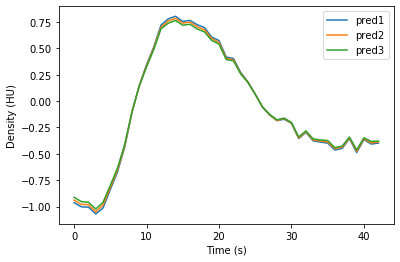

In [22]:
pred1 = model.predict(np.expand_dims(normalize(ctp_volumes[10]['ctpvals']), axis=0))[0]
pred2 = model.predict(np.expand_dims(normalize(ctp_volumes[20]['ctpvals']), axis=0))[0]
pred3 = model.predict(np.expand_dims(normalize(ctp_volumes[30]['ctpvals']), axis=0))[0]
plt.plot(-pred1)
plt.plot(-pred2)
plt.plot(-pred3)
plt.legend(['pred1', 'pred2','pred3'])
plt.xlabel('Time (s)')
plt.ylabel('Density (HU)')
plt.show()


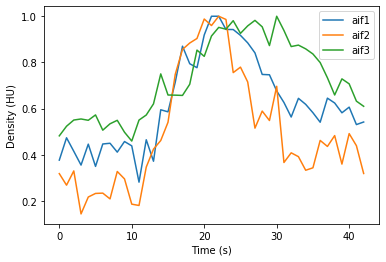

In [21]:
case_id1 = ctp_volumes[10]['image'].split('.')[-2]
case_id2 = ctp_volumes[20]['image'].split('.')[-2]
case_id3 = ctp_volumes[30]['image'].split('.')[-2]

label_aif1 = normalize_aif(aif_annotations[case_id1])
label_aif2 = normalize_aif(aif_annotations[case_id2])
label_aif3 = normalize_aif(aif_annotations[case_id3])


plt.plot(label_aif1)
plt.plot(label_aif2)
plt.plot(label_aif3)
plt.legend(['aif1', 'aif2','aif3'])
plt.xlabel('Time (s)')
plt.ylabel('Density (HU)')
plt.show()
